In [2]:
from core.validator import load_saved_split, load_train_split
from pipeline import DomainClassifier
import sys

MALICIOUS_LABEL = "phishing"
STAGE = 3
VERIFICATION = True

x_train_additional, y_test_additional = load_saved_split(STAGE, MALICIOUS_LABEL, folder="./data/", verification=VERIFICATION)



DomainClassifier = DomainClassifier(data_sample = x_train_additional, label=MALICIOUS_LABEL)

DomainClassifier.determine_stage(x_train_additional)

fp = 0
fn = 0
tp = 0
tn = 0

for domain, result in zip(x_train_additional, y_test_additional):
    final_class = DomainClassifier.classify_proba(domain)['final_proba']
    
    print(f"Domain: {domain}, Result: {result}, Final Class: {final_class}")
    
    if result == 1 and final_class > 0.5:
        tp += 1
    elif result == 1 and final_class <= 0.5:
        fn += 1
    elif result == 0 and final_class > 0.5:
        fp += 1
    elif result == 0 and final_class <= 0.5:
        tn += 1
    else:
        print("Error in classification")
        print(domain, result, final_class)
        sys.exit(1)



Stage determined: 3
Stage: 3
📦 Loading model from models/cnn_stage_3_phishing_v1.1.keras


2025-05-13 17:14:07.413544: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2025-05-13 17:14:07.413594: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: poli
2025-05-13 17:14:07.413601: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: poli
2025-05-13 17:14:07.413803: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 570.133.7
2025-05-13 17:14:07.413854: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  570.86.10  Release Build  (dvs-builder@U16-I3-B16-4-3)  Thu Jan 16 03:40:42 UTC 2025
GCC version:  gcc versio

📦 Loading model from models/svm_stage_3_phishing_v1.1.pkl
📦 Loading model from models/XgBoost_stage_3_phishing_v1.1.xgb
📦 Loading model from models/Lgbm_stage_3_phishing_v1.1.pkl
📦 Loading model from models/feedforward_stage_3_phishing_v1.1.keras
Stage determined: 3
[CNN] X_test reshaped to (1, 14, 14, 1) (side 14, padded by 20)
1/1 [==============================] - 0s 113ms/step
🔄 Detected SVM, using: scalers/phishing_svm_3_scaler.joblib scaler
1/1 [==============================] - 0s 67ms/step
Domain: [1.0 0 0 0 0 0 0 0 0 0 4 0.5 0 0.0 0.0 0.0 1.0 0.0 1.0 -1.0 -1.0 -1.0 -1.0
 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 False -1.0 -1.0 -1.0 -1.0 0 0 0 0
 0 0.0 0.0 0.0 0.0 -1.0 -1.0 -1.0 False -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
 -1.0 -1.0 22 0 1 1 2 4 0.0 3208175356 12 0.27096909728231855 0.0 0.0 0 5
 0.4166666666666667 8 0.6666666666666666 0 0.0 3 0.25 1 11 0 0 2
 0.21580122069467395 0.0 0.0 7 0.4375 10 0.625 0 0.0 4

KeyboardInterrupt: 

In [1]:
import os
import time
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from core.validator import load_saved_split
from pipeline import DomainClassifier

STAGE = 2
VERIFICATION = True
LABELS = ["phishing", "malware"]
SAVE_PATH = "tex_sources/pipeline_verif.tex"

os.makedirs("tex_sources", exist_ok=True)

results = []

for label in LABELS:
    print(f"\n=== Evaluating {label.upper()} (Stage {STAGE}) ===")

    # Load test data
    x_data, y_data = load_saved_split(STAGE, label, folder="./data/", verification=VERIFICATION)
    x_data = x_data[:10000]
    y_data = y_data[:10000]

    clf = DomainClassifier(stage=STAGE, label=label)

    y_true = []
    y_pred = []
    y_proba = []

    start_time = time.time()

    for x, true_label in zip(x_data, y_data):
        result = clf.classify_proba(x)
        final_proba = result["final_proba"]
        pred_label = 1 if final_proba > 0.5 else 0
        y_true.append(true_label)
        y_pred.append(pred_label)
        y_proba.append(final_proba)

    elapsed = time.time() - start_time
    speed = len(y_true) / elapsed

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Metrics
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
    auc = roc_auc_score(y_true, y_proba)
    
    stage_results = {
        "Stage": STAGE,
        "Label": label,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": auc,
        "Domains/sec": round(speed, 2),
    }

    results.append(stage_results)
    print(f"Stage results: {stage_results}")
    
    

# Save results to LaTeX
with open(SAVE_PATH, "w") as f:
    for result in results:
        f.write(f"""\\begin{{table}}[H]
\\centering
\\begin{{tabular}}{{|l|c|}}
\\hline
\\textbf{{Metrika}} & \\textbf{{{result['Label'].capitalize()}}} \\\\
\\hline
Přesnost (Accuracy) & \\texttt{{{result['Accuracy']:.4f}}} \\\\
Precision (Přesnost) & \\texttt{{{result['Precision']:.4f}}} \\\\
Recall (Úplnost) & \\texttt{{{result['Recall']:.4f}}} \\\\
F1 Skóre & \\texttt{{{result['F1 Score']:.4f}}} \\\\
ROC AUC & \\texttt{{{result['ROC AUC']:.4f}}} \\\\
\\hline
\\end{{tabular}}
\\caption{{Výsledky klasifikace {result['Label']} domén – verifikační sada}}
\\label{{tab:final_pipeline_ver_{result['Label']}_{result['Stage']}}}
\\end{{table}}

""")

print(f"Saved LaTeX results to: {SAVE_PATH}")


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2025-05-04 13:49:58.247569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-04 13:49:58.247667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-04 13:49:58.281246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 13:49:58.351734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other 


=== Evaluating PHISHING (Stage 2) ===
2 phishing ./data/
📦 Loading model from models/XgBoost_stage_2_phishing_v1.1.xgb
📦 Loading model from models/Lgbm_stage_2_phishing_v1.1.pkl
📦 Loading model from models/feedforward_stage_2_phishing_v1.1.keras


2025-05-04 13:50:01.412330: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-04 13:50:01.571510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-04 13:50:01.574662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Stage results: {'Stage': 2, 'Label': 'phishing', 'Accuracy': 0.9711191335740073, 'Precision': 0.8992805755395683, 'Recall': 0.9259259259259259, 'F1 Score': 0.9124087591240876, 'ROC AUC': 0.9661132396764581, 'Domains/sec': 10.55}

=== Evaluating MALWARE (Stage 2) ===
2 malware ./data/
📦 Loading model from models/XgBoost_stage_2_malware_v1.1.xgb
📦 Loading model from models/Lgbm_stage_2_malware_v1.1.pkl
📦 Loading model from models/feedforward_stage_2_malware_v1.1.keras
Stage results: {'Stage': 2, 'Label': 'malware', 'Accuracy': 0.8972972972972973, 'Precision': 0.38181818181818183, 'Recall': 0.84, 'F1 Score': 0.525, 'ROC AUC': 0.9226086956521738, 'Domains/sec': 11.05}
Saved LaTeX results to: tex_sources/pipeline_verif.tex


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2025-05-04 21:58:52.194004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-04 21:58:52.194032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-04 21:58:52.195193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 21:58:52.201351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other 


=== Evaluating PHISHING (Stage 3) ===
3 phishing ./data/
Columns: Index(['dns_has_dnskey', 'dns_A_count', 'dns_AAAA_count', 'dns_MX_count',
       'dns_NS_count', 'dns_TXT_count', 'dns_SOA_count', 'dns_CNAME_count',
       'dns_zone_level', 'dns_zone_digit_count',
       ...
       'rdap_ip_v4_count', 'rdap_ip_v6_count',
       'rdap_ip_shortest_v4_prefix_len', 'rdap_ip_longest_v4_prefix_len',
       'rdap_ip_shortest_v6_prefix_len', 'rdap_ip_longest_v6_prefix_len',
       'rdap_ip_avg_admin_name_len', 'rdap_ip_avg_admin_name_entropy',
       'rdap_ip_avg_admin_email_len', 'rdap_ip_avg_admin_email_entropy'],
      dtype='object', length=176)
📦 Loading model from models/svm_stage_3_phishing_v1.1.pkl
📦 Loading model from models/XgBoost_stage_3_phishing_v1.1.xgb
📦 Loading model from models/Lgbm_stage_3_phishing_v1.1.pkl
📦 Loading model from models/feedforward_stage_3_phishing_v1.1.keras


2025-05-04 21:59:06.331386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-04 21:59:06.371054: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-04 21:59:06.373905: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Generating SHAP for svm...


Permutation explainer: 101it [2:50:26, 102.27s/it]                          
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Generating SHAP for XgBoost...


Permutation explainer: 101it [00:19,  2.80it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


Generating SHAP for Lgbm...


Permutation explainer: 101it [00:11,  1.11s/it]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


Generating SHAP for feedforward...
461/461 [==============================] - 0s 896us/step


Permutation explainer:   6%|▌         | 6/100 [00:00<?, ?it/s]

424/424 [==============================] - 0s 920us/step


Permutation explainer:   8%|▊         | 8/100 [00:12<01:08,  1.34it/s]

457/457 [==============================] - 0s 888us/step


Permutation explainer:   9%|▉         | 9/100 [00:14<02:01,  1.33s/it]

425/425 [==============================] - 0s 884us/step


Permutation explainer:  10%|█         | 10/100 [00:16<02:13,  1.48s/it]

436/436 [==============================] - 0s 912us/step


Permutation explainer:  11%|█         | 11/100 [00:17<02:20,  1.58s/it]

433/433 [==============================] - 0s 898us/step


Permutation explainer:  12%|█▏        | 12/100 [00:19<02:19,  1.59s/it]

423/423 [==============================] - 0s 889us/step


Permutation explainer:  13%|█▎        | 13/100 [00:20<02:14,  1.55s/it]

417/417 [==============================] - 0s 883us/step


Permutation explainer:  14%|█▍        | 14/100 [00:22<02:10,  1.52s/it]

404/404 [==============================] - 0s 879us/step


Permutation explainer:  15%|█▌        | 15/100 [00:24<02:14,  1.58s/it]

428/428 [==============================] - 0s 890us/step


Permutation explainer:  16%|█▌        | 16/100 [00:25<02:13,  1.58s/it]

429/429 [==============================] - 0s 898us/step


Permutation explainer:  17%|█▋        | 17/100 [00:27<02:13,  1.61s/it]

492/492 [==============================] - 0s 885us/step


Permutation explainer:  18%|█▊        | 18/100 [00:30<02:42,  1.98s/it]

445/445 [==============================] - 0s 893us/step


Permutation explainer:  19%|█▉        | 19/100 [00:31<02:28,  1.83s/it]

456/456 [==============================] - 0s 890us/step


Permutation explainer:  20%|██        | 20/100 [00:33<02:29,  1.87s/it]

422/422 [==============================] - 0s 885us/step


Permutation explainer:  21%|██        | 21/100 [00:35<02:17,  1.74s/it]

416/416 [==============================] - 0s 889us/step


Permutation explainer:  22%|██▏       | 22/100 [00:36<02:11,  1.69s/it]

419/419 [==============================] - 0s 891us/step


Permutation explainer:  23%|██▎       | 23/100 [00:38<02:06,  1.64s/it]

415/415 [==============================] - 0s 875us/step


Permutation explainer:  24%|██▍       | 24/100 [00:39<02:03,  1.62s/it]

436/436 [==============================] - 0s 883us/step


Permutation explainer:  25%|██▌       | 25/100 [00:41<01:58,  1.58s/it]

446/446 [==============================] - 0s 893us/step


Permutation explainer:  26%|██▌       | 26/100 [00:42<01:58,  1.60s/it]

398/398 [==============================] - 0s 874us/step


Permutation explainer:  27%|██▋       | 27/100 [00:44<01:52,  1.54s/it]

397/397 [==============================] - 0s 909us/step


Permutation explainer:  28%|██▊       | 28/100 [00:45<01:46,  1.48s/it]

424/424 [==============================] - 0s 882us/step


Permutation explainer:  29%|██▉       | 29/100 [00:47<01:43,  1.46s/it]

423/423 [==============================] - 0s 875us/step


Permutation explainer:  30%|███       | 30/100 [00:48<01:40,  1.44s/it]

435/435 [==============================] - 0s 895us/step


Permutation explainer:  31%|███       | 31/100 [00:50<01:40,  1.46s/it]

393/393 [==============================] - 0s 887us/step


Permutation explainer:  32%|███▏      | 32/100 [00:51<01:37,  1.43s/it]

403/403 [==============================] - 0s 885us/step


Permutation explainer:  33%|███▎      | 33/100 [00:52<01:34,  1.41s/it]

399/399 [==============================] - 0s 895us/step


Permutation explainer:  34%|███▍      | 34/100 [00:54<01:31,  1.39s/it]

477/477 [==============================] - 0s 893us/step


Permutation explainer:  35%|███▌      | 35/100 [00:55<01:38,  1.51s/it]

436/436 [==============================] - 0s 888us/step


Permutation explainer:  36%|███▌      | 36/100 [00:57<01:37,  1.52s/it]

399/399 [==============================] - 0s 867us/step


Permutation explainer:  37%|███▋      | 37/100 [00:58<01:31,  1.46s/it]

403/403 [==============================] - 0s 869us/step


Permutation explainer:  38%|███▊      | 38/100 [01:00<01:27,  1.42s/it]

456/456 [==============================] - 0s 867us/step


Permutation explainer:  39%|███▉      | 39/100 [01:01<01:28,  1.45s/it]

450/450 [==============================] - 0s 869us/step


Permutation explainer:  40%|████      | 40/100 [01:03<01:30,  1.50s/it]

446/446 [==============================] - 0s 870us/step


Permutation explainer:  41%|████      | 41/100 [01:04<01:26,  1.47s/it]

422/422 [==============================] - 0s 899us/step


Permutation explainer:  42%|████▏     | 42/100 [01:05<01:24,  1.45s/it]

411/411 [==============================] - 0s 879us/step


Permutation explainer:  43%|████▎     | 43/100 [01:07<01:21,  1.42s/it]

396/396 [==============================] - 0s 880us/step


Permutation explainer:  44%|████▍     | 44/100 [01:08<01:18,  1.41s/it]

423/423 [==============================] - 0s 935us/step


Permutation explainer:  45%|████▌     | 45/100 [01:10<01:19,  1.45s/it]

389/389 [==============================] - 0s 865us/step


Permutation explainer:  46%|████▌     | 46/100 [01:11<01:16,  1.41s/it]

446/446 [==============================] - 0s 880us/step


Permutation explainer:  47%|████▋     | 47/100 [01:13<01:18,  1.47s/it]

409/409 [==============================] - 0s 903us/step


Permutation explainer:  48%|████▊     | 48/100 [01:14<01:14,  1.44s/it]

442/442 [==============================] - 0s 865us/step


Permutation explainer:  49%|████▉     | 49/100 [01:16<01:15,  1.47s/it]

409/409 [==============================] - 0s 879us/step


Permutation explainer:  50%|█████     | 50/100 [01:17<01:18,  1.58s/it]

434/434 [==============================] - 0s 856us/step


Permutation explainer:  51%|█████     | 51/100 [01:19<01:16,  1.57s/it]

470/470 [==============================] - 0s 884us/step


Permutation explainer:  52%|█████▏    | 52/100 [01:21<01:23,  1.75s/it]

399/399 [==============================] - 0s 925us/step


Permutation explainer:  53%|█████▎    | 53/100 [01:22<01:16,  1.62s/it]

386/386 [==============================] - 0s 872us/step


Permutation explainer:  54%|█████▍    | 54/100 [01:24<01:09,  1.50s/it]

402/402 [==============================] - 0s 864us/step


Permutation explainer:  55%|█████▌    | 55/100 [01:25<01:05,  1.45s/it]

419/419 [==============================] - 0s 885us/step


Permutation explainer:  56%|█████▌    | 56/100 [01:27<01:04,  1.46s/it]

462/462 [==============================] - 0s 891us/step


Permutation explainer:  57%|█████▋    | 57/100 [01:28<01:08,  1.60s/it]

396/396 [==============================] - 0s 886us/step


Permutation explainer:  58%|█████▊    | 58/100 [01:30<01:03,  1.52s/it]

433/433 [==============================] - 0s 892us/step


Permutation explainer:  59%|█████▉    | 59/100 [01:31<01:03,  1.54s/it]

454/454 [==============================] - 0s 915us/step


Permutation explainer:  60%|██████    | 60/100 [01:33<01:01,  1.54s/it]

425/425 [==============================] - 0s 905us/step


Permutation explainer:  61%|██████    | 61/100 [01:34<00:58,  1.50s/it]

405/405 [==============================] - 0s 887us/step


Permutation explainer:  62%|██████▏   | 62/100 [01:36<00:55,  1.47s/it]

452/452 [==============================] - 0s 886us/step


Permutation explainer:  63%|██████▎   | 63/100 [01:37<00:55,  1.51s/it]

408/408 [==============================] - 0s 916us/step


Permutation explainer:  64%|██████▍   | 64/100 [01:39<00:53,  1.48s/it]

427/427 [==============================] - 0s 895us/step


Permutation explainer:  65%|██████▌   | 65/100 [01:40<00:51,  1.48s/it]

392/392 [==============================] - 0s 875us/step


Permutation explainer:  66%|██████▌   | 66/100 [01:42<00:48,  1.44s/it]

458/458 [==============================] - 0s 872us/step


Permutation explainer:  67%|██████▋   | 67/100 [01:43<00:49,  1.49s/it]

457/457 [==============================] - 0s 875us/step


Permutation explainer:  68%|██████▊   | 68/100 [01:45<00:49,  1.55s/it]

465/465 [==============================] - 0s 875us/step


Permutation explainer:  69%|██████▉   | 69/100 [01:47<00:52,  1.70s/it]

478/478 [==============================] - 0s 884us/step


Permutation explainer:  70%|███████   | 70/100 [01:49<00:51,  1.72s/it]

431/431 [==============================] - 0s 900us/step


Permutation explainer:  71%|███████   | 71/100 [01:50<00:48,  1.69s/it]

425/425 [==============================] - 0s 878us/step


Permutation explainer:  72%|███████▏  | 72/100 [01:52<00:45,  1.62s/it]

399/399 [==============================] - 0s 881us/step


Permutation explainer:  73%|███████▎  | 73/100 [01:53<00:42,  1.57s/it]

469/469 [==============================] - 0s 908us/step


Permutation explainer:  74%|███████▍  | 74/100 [01:55<00:42,  1.63s/it]

446/446 [==============================] - 0s 866us/step


Permutation explainer:  75%|███████▌  | 75/100 [01:57<00:41,  1.64s/it]

408/408 [==============================] - 0s 891us/step


Permutation explainer:  76%|███████▌  | 76/100 [01:58<00:37,  1.55s/it]

465/465 [==============================] - 0s 879us/step


Permutation explainer:  77%|███████▋  | 77/100 [02:00<00:36,  1.57s/it]

423/423 [==============================] - 0s 875us/step


Permutation explainer:  78%|███████▊  | 78/100 [02:01<00:32,  1.49s/it]

445/445 [==============================] - 0s 887us/step


Permutation explainer:  79%|███████▉  | 79/100 [02:02<00:31,  1.49s/it]

414/414 [==============================] - 0s 879us/step


Permutation explainer:  80%|████████  | 80/100 [02:04<00:29,  1.46s/it]

467/467 [==============================] - 0s 884us/step


Permutation explainer:  81%|████████  | 81/100 [02:06<00:31,  1.67s/it]

464/464 [==============================] - 0s 885us/step


Permutation explainer:  82%|████████▏ | 82/100 [02:08<00:32,  1.81s/it]

444/444 [==============================] - 0s 887us/step


Permutation explainer:  83%|████████▎ | 83/100 [02:10<00:29,  1.75s/it]

434/434 [==============================] - 0s 906us/step


Permutation explainer:  84%|████████▍ | 84/100 [02:11<00:27,  1.72s/it]

435/435 [==============================] - 0s 898us/step


Permutation explainer:  85%|████████▌ | 85/100 [02:13<00:26,  1.78s/it]

449/449 [==============================] - 0s 892us/step


Permutation explainer:  86%|████████▌ | 86/100 [02:15<00:24,  1.76s/it]

454/454 [==============================] - 0s 870us/step


Permutation explainer:  87%|████████▋ | 87/100 [02:16<00:21,  1.67s/it]

402/402 [==============================] - 0s 864us/step


Permutation explainer:  88%|████████▊ | 88/100 [02:18<00:19,  1.59s/it]

437/437 [==============================] - 0s 920us/step


Permutation explainer:  89%|████████▉ | 89/100 [02:19<00:17,  1.59s/it]

460/460 [==============================] - 0s 864us/step


Permutation explainer:  90%|█████████ | 90/100 [02:21<00:15,  1.57s/it]

424/424 [==============================] - 0s 874us/step


Permutation explainer:  91%|█████████ | 91/100 [02:22<00:13,  1.52s/it]

469/469 [==============================] - 0s 881us/step


Permutation explainer:  92%|█████████▏| 92/100 [02:24<00:12,  1.55s/it]

455/455 [==============================] - 0s 903us/step


Permutation explainer:  93%|█████████▎| 93/100 [02:26<00:11,  1.60s/it]

424/424 [==============================] - 0s 901us/step


Permutation explainer:  94%|█████████▍| 94/100 [02:27<00:09,  1.52s/it]

472/472 [==============================] - 0s 882us/step


Permutation explainer:  95%|█████████▌| 95/100 [02:29<00:07,  1.53s/it]

419/419 [==============================] - 0s 887us/step


Permutation explainer:  96%|█████████▌| 96/100 [02:30<00:05,  1.47s/it]

429/429 [==============================] - 0s 874us/step


Permutation explainer:  97%|█████████▋| 97/100 [02:31<00:04,  1.42s/it]

448/448 [==============================] - 0s 882us/step


Permutation explainer:  98%|█████████▊| 98/100 [02:33<00:02,  1.46s/it]

472/472 [==============================] - 0s 870us/step


Permutation explainer:  99%|█████████▉| 99/100 [02:34<00:01,  1.50s/it]

405/405 [==============================] - 0s 882us/step


Permutation explainer: 100%|██████████| 100/100 [02:36<00:00,  1.42s/it]

431/431 [==============================] - 0s 861us/step


Permutation explainer: 101it [02:37,  1.66s/it]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_317715/2543472031.py", line 21, in <module>
    _, X_test, _, _, columns =load_train_split(STAGE, label, folder="./data/")
  File "/home/poli/Desktop/git/deep_domain_detection/src/core/validator.py", line 50, in load_train_split
FileNotFoundError: [Errno 2] No such file or directory: './data/whole_split_3_malware.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback


=== Evaluating MALWARE (Stage 3) ===
3 malware ./data/
Unexpected exception formatting exception. Falling back to standard exception


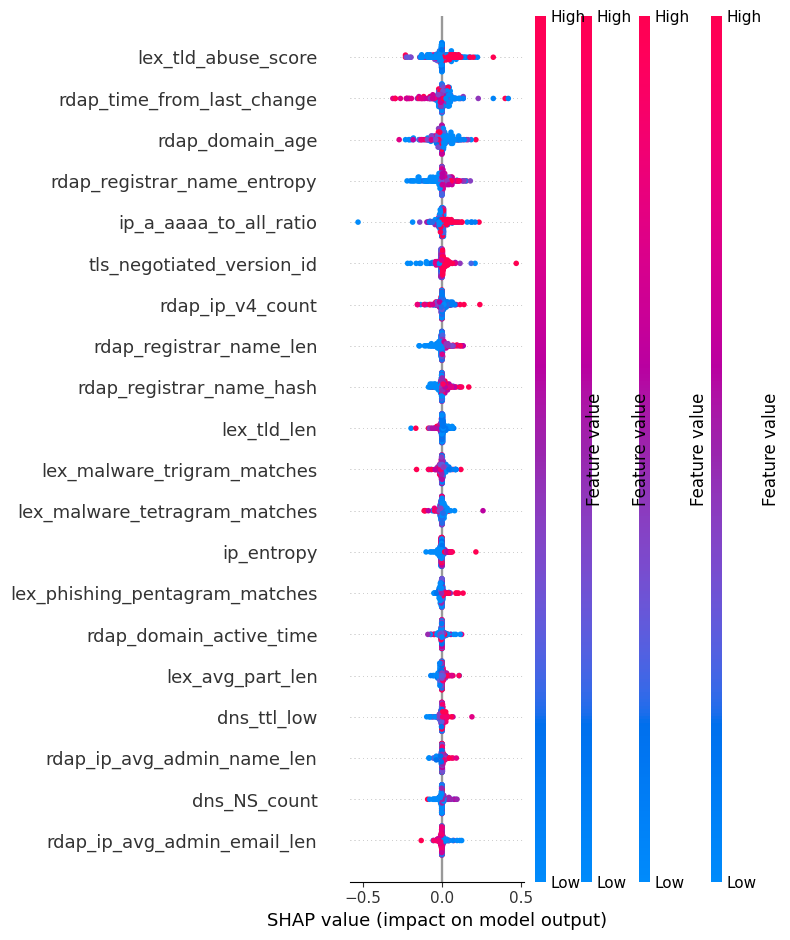

: 

In [ ]:
from core.validator import load_saved_split, load_train_split
from sklearn.metrics import confusion_matrix, classification_report
import time
import pandas as pd
from pipeline import DomainClassifier
import numpy as np

STAGE = 3
VERIFICATION = True
LABELS = ["phishing", "malware"]

results = []

for label in LABELS:
    print(f"\n=== Evaluating {label.upper()} (Stage {STAGE}) ===")

    # Load test data
    # x_data, y_data = load_saved_split(STAGE, label, folder="./data/", verification=VERIFICATION)
    

    _, X_test, _, _, columns =load_train_split(STAGE, label, folder="./data/")
    

 

    # Init classifier once
    clf = DomainClassifier(stage=STAGE, label=label)
    

        
    X_test = X_test.astype(np.float32)[:100]

    clf.explain_shap(X_test, columns)
